In [1]:
import earthaccess
import xarray as xr
import pprint
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import time



I wanted to visualize the ATL06 tracks that intersect a polygon covering the Cook ice shelf.   The goal was to have latitude, longitude, height, and ATL06 quality for all the tracks that intersect the region within a specified date range. My plan was:
1. find the granules with a CMR search
2. Read latitude and longitude from the granules to define the range of segment indexes needed from each track in each granule
3. Read latitude, longitude, h_li and atl06_quality_summary for the index ranges from each track in each granule.

I tried this on CryoCloud, where access to cloud-hosted granules should be relatively fast.  It turned out that step 1 was fast, but steps 2 and 3 each took around 2.5 min to read one ground track from each of 14 granules, which is too slow for on-the-fly data access.

### 1a. Read the geometry

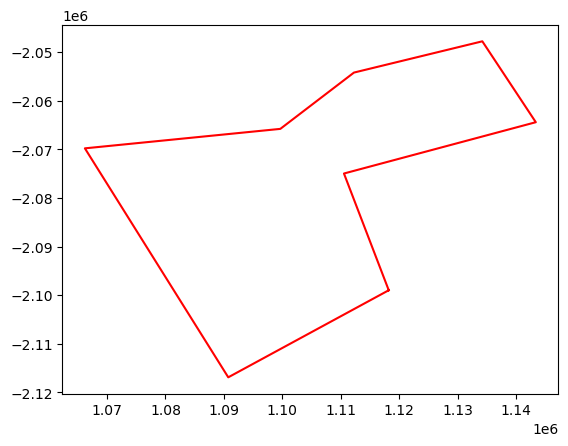

In [2]:
df = gpd.read_file('Cook_subset.kml')
geom_xy =df.to_crs(3031).geometry[0]
geom_ll = df.geometry[0]
plt.plot(*np.array(geom_xy.exterior.coords)[:, 0:2].T,'r')

### 1b. use earthaccess search to find the granules

In [3]:
%%time
earthaccess_poly = [(jj[0], jj[1]) for jj in np.array(geom_ll.exterior.coords)]

results = earthaccess.search_data(
    short_name = 'ATL06',
    version = '006',
    cloud_hosted = True,
    polygon=earthaccess_poly,      
    temporal = ('2019-10-01','2020-03-01'),
)

files=earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 223 ms, sys: 39.8 ms, total: 263 ms
Wall time: 3.87 s


### 1b: Make an index of granules by track

In [4]:
import re
track_re=re.compile('ATL06_\d+_(\d\d\d\d)')

track_files = {}
for file in files:
    track=int(track_re.search(file.full_name).group(1))
    if track not in track_files:
        track_files[track]=[]
    track_files[track] += [file]


### 2. Read latitude and longitude for each granule

CPU times: user 42.9 s, sys: 22 s, total: 1min 4s
Wall time: 2min 49s


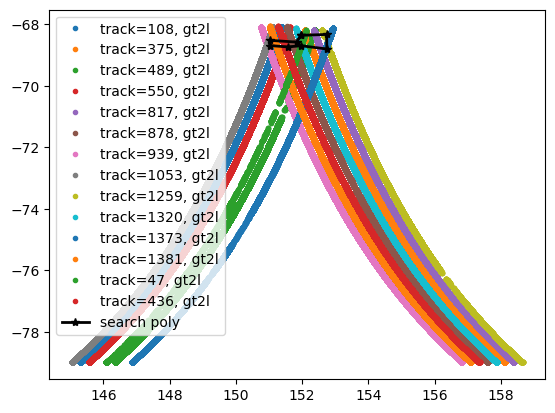

In [5]:
%%time

plt.figure()
lonlat_for_track={}
for track, files in track_files.items():
    ds = xr.open_dataset(files[0], group='/gt2l/land_ice_segments')
    lonlat_for_track[track]=np.c_[ds.longitude, ds.latitude]
    plt.plot(*lonlat_for_track[track].T,'.', label=f'track={track}, gt2l')
    
plt.plot(*np.array(geom_ll.exterior.coords)[:, 0:2].T,'black', linewidth=2, marker='*', label='search poly')
plt.legend()

### Issue 1:
Running the previous cell on CryoCloud took 3 minutes to read gt2l from each granule. Running this for all three strong beams would likely take ~6 minutes.  


### 2b/3: select the data points within the bounds of the polygon and read full records for each:


This is a test to see if xarray is doing a good job of lazy indexing for the ATL06 objects.  If it is, then reading only a small range of data points should be much faster than reading the entire datasets.

Here for each data point, we read five fields: latitude, longitude, h_li, atl06_quality_summary, and delta_time

CPU times: user 40.1 s, sys: 20.6 s, total: 1min
Wall time: 2min 31s


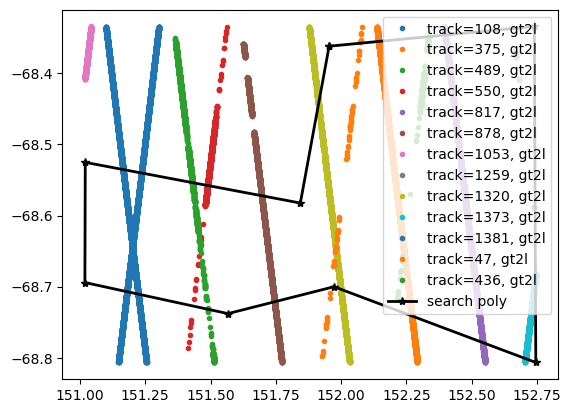

In [6]:
%%time
bds=np.array(geom_ll.bounds).reshape(2,2).T
data_sub={}

plt.figure()
fields = ['latitude','longitude','h_li','atl06_quality_summary','delta_time']

for track, files in track_files.items():
    lonlat = lonlat_for_track[track]
    ind = np.flatnonzero((lonlat[:,0] > bds[0][0]) 
                         & (lonlat[:,0] < bds[0][1]) 
                         &(lonlat[:,1] > bds[1][0]) 
                         & (lonlat[:,1] < bds[1][1]) ) 
    if len(ind)==0:
        continue
                         
    ds = xr.open_dataset(files[0], group='/gt2l/land_ice_segments')
    data_sub[track] = {field:np.array(ds[field][ind[0]:ind[-1]]) for field in fields}
    plt.plot(data_sub[track]['longitude'], data_sub[track]['latitude'],
             '.', label=f'track={track}, gt2l')

plt.plot(*np.array(geom_ll.exterior.coords)[:, 0:2].T,'black', linewidth=2, marker='*', label='search poly')
plt.legend()


## Issue 2: 
This step is a little bit faster than reading the whole granules, but still takes around 2.5 min for gt2l.